## Artigo 1 - AI para reconhecimento de cidades

### 1. Introdução

Na última década, o campo da inteligência articial apresentou avanços surpreendentes. Através do aprendizado de máquinas, é possível criar programas que realizam tarefas antes pensadas impossíveis para um computador, como por exemplo, analisar e compreender o conteúdo de uma imagem com precisão.

O curso _Practical Deep Learning for Coders 2022_, ensinado por Jeremy Howard, utiliza-se de uma metodologia _top-down_, onde ao invés de aprender os fundamentos básicos do tema em questão, é mostrada uma aplicação real, e depois vem o aprofundamento do que foi utilizado. Portanto a primeira lição já conta com criação e treinamento de uma rede neural na prática.

### 2. Objetivo
Me familiarizar com as ferramentas disponibilizadas pelo FastAI para o desenvolvimento de redes neurais, e a utilização do Jupyter Notebook para criação de cadernos interativos capazes de rodar código em tempo real.

### 3. Inspiração

Quando assisti a lição 1 do curso, logo pensei no jogo web [GeoGuessr](https://www.geoguessr.com/), onde o jogador é colocado em uma localização aleatória no mapa e deve descobrir onde se encontra utilizando-se do _StreetView_ do Google Maps.

<img src="img/geogssr.png" alt="geo" width="800" /><br>
<em> [1] Exemplo de uma rodada de GeoGuessr </em>

Então decidi ver se era possível criar um modelo capaz de diferenciar entre fotos de cidades européias e fotos de cidades asiáticas, apenas com o conhecimento adquirido nessa primeira aula.

###  4. Execução

#### 4.1 Adquirir dados

In [1]:
# Código para ignorar avisos de usuário
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

Seguindo o caderno da primeira lição disponibilizado no [Keggle](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data/notebook), o primeiro passo é utilizar a biblioteca do DuckDuckGO para realizar pesquisas na internet e adquirir a url de uma imagem.

In [52]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=100):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

urls = search_images('european city', max_images=1)
urls[0]

Searching for 'european city'


'https://www.travelrepublic.co.uk/blog/wp-content/uploads/2018/07/Amsterdam-TravelRepublic-iStock-868776864.jpg'

Utilizando bibliotecas do `fastai`, podemos então baixar aquela url e visualizar a imagem.

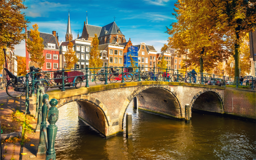

In [17]:
from fastdownload import download_url
from fastai.vision.all import *

dest = 'europe.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256,256)

Faremos o mesmo para cidades asiáticas, dessa vez de uma maneira mais compacta.

Searching for 'asian city'


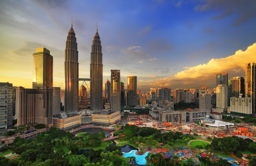

In [24]:
download_url(search_images('asian city', max_images=1)[0], 'asia.jpg', show_progress=False)
Image.open('asia.jpg').to_thumb(256,256)

O código a seguir pesquisa exemplos de cidades européias e asiáticas para serem usados no treinamento do nosso modelo, e salva as imagens em pastas separadas.

In [56]:
searches = 'asian','european'
path = Path('geoguess')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} city')) 
    sleep(50)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'asian city'
Searching for 'european city'


A função `dest.mkdir()` cria uma pasta no caminho salvo em dest, que será 'geoguess/asian' ou 'geoguess/european'

A função `download_images()` recebe a lista de urls entregue pela `search_images()` e baixa as imagens para o destino 'dest'.

A função `resize_images()` modifica o tamanho de todas as imagens para 400px, que é mais do que o suficienta para o reconhecimento de imagens do nosso modelo.

A seguir, verificamos as imagens baixadas, e caso alguma esteja corrompida, removemos do teste. 

In [57]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
print(f"Imagens inacessíveis: {len(failed)}")

Imagens inacessíveis: 4


#### 4.2 Preparações para o treinamento

Para o treinamento do modelo, utilizaremos `DataLoaders`, que são objetos contendo:
- Conjunto de treinamento: imagens utilizadas para criar um modelo
- Conjunto de validação: imagens utilizadas para testar a precisão do modelo
A biblioteca do `fastai` nos proporciona a classe `DataBlock`, que pode ser usada para este objetivo.

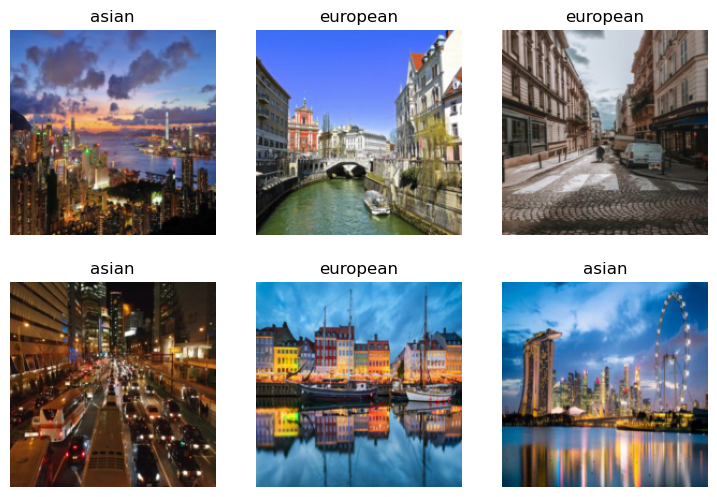

In [58]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

O `DataBlock` possui os seguintes parâmetros:

    blocks=(ImageBlock, CategoryBlock),

Define o tipo da entrada do modelo, no caso imagens, e a saída, sendo categorias (cidade européia ou asiática).

    get_items=get_image_files, 

Encontra as entradas através da função `get_image_files` que retorna uma lista de todas as imagens em um destino.

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Separa os dados aleatoriamente em grupos para treinamento ou validação, onde a validação representa 20% do total de dados.

    get_y=parent_label,

As legendas (chamadas aqui de `y`) serão o nome da pasta em que se localiza as imagens.

    item_tfms=[Resize(192, method='squish')]

Enfim, modifica o tamanho das imagens para 192x192 pixels utilizando o método "squishing", onde a imagem é achatada ao invés de cortada.

#### 4.3 Treinamento

Agora o modelo está pronto para ser treinado. Para isso, precisamos de um modelo de visão computacional, no caso o `resnet18`, que foi sugerido por sua velocidade e popularidade.

E para finalizar, utilizamos o método `fine_tune()` disponibilizado pela biblioteca do `fastai` para calibrar nosso modelo pré-treinado.

In [67]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.285022,1.222921,0.400000,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.784648,0.629922,0.314286,00:01
1,0.589685,0.584107,0.200000,00:01
2,0.418229,0.526569,0.200000,00:01
3,0.317264,0.503867,0.200000,00:01


##### Observação:
    A versão mais nova do `PyTorch` (1.13), apresenta o seguinte erro no comando `fine_tune()`:
    "unsupported format string passed to TensorBase.__format__"
    Enquanto esse problema não é resolvido, resolvi alterar a versão utilizada para a 1.12.1, onde o mesmo comando executa sem problemas.     

"Fine-tuning" ou "Calibrar" um modelo significa usar um modelo que já foi treinado utilizando outro grupo de dados, e ajustando os pesos para que o modelo pré-treinado reconheça nosso grupo de dados. O modelo utilizado foi treinado para reconhecer imagens em *imagenet*, um grupo de dados popular com imagens cobrindo 1000 categorias.

No treinamento realizado pelo guia, e em testes que eu fiz anteriormente, o `error_rate` final era 0.0, mas para esse caso foi de 0.2. Imagino que seja porque anteriormente eram comparadas duas coisas totalmente diferentes, como pássaros e árvores, ou lagartos e praias, enquanto no meu caso a diferença entre as categorias é mais sutil. Espero que mais pra frente no curso eu possa aprender um meio de melhorar a precisão desse modelo.

#### 4.4 Testando o modelo

Por fim podemos passar uma imagem para o nosso modelo através do método `.predict()`, e receber o resultado, além de valores que indicam o quão certo ele está de que acertou.

This city is european.
Probabilities: 	Asia: 0.0000	Europe: 1.0000


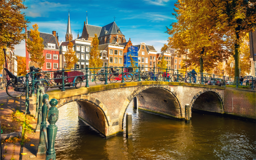

In [68]:
image = PILImage.create('europe.jpg')
prediction,_,probs = learn.predict(image)
print(f"This city is {prediction}.")
print(f"Probabilities: \tAsia: {probs[0]:.4f}\tEurope: {probs[1]:.4f}")
image.to_thumb(256,256)

E pronto! O modelo se mostrou capaz de reconhecer corretamente uma cidade como européia, apesar do `error_rate` acima do esperado.

### 5. Conclusão

Após várias dificuldades com o Jupyter, três instalações das bibliotecas necessárias, e horas pesquisando problemas, enfim tudo funcionou.<p>
Sinto que o que eu adquiri com essa aula foi muito mais do que algumas linhas de código; apesar do começo complicado, adorei trabalhar com o Jupyter e com certeza vou implementar essa ferramenta em mais lugares, e após ver o quão acessível é o treinamento de modelos, fiquei curioso para encontrar aplicações para esse conhecimento.<p>
Não esperava que o modelo fosse capaz de diferenciar cidades de diferentes continentes com apenas uma foto, mas fui surpreendido. Estou ansioso para ver o que mais será possível fazer ao longo desse curso.